--- Processing ER1 ---
Found Temp Dir: .\ER1-20251125T132711Z-1-001\ER1\OCEAN_TEMPERATURE
Found MLD Dir:  .\ER1-20251125T132711Z-1-001\ER1\MIXED_LAYER_DEPTH
Loading files individually to fix coordinate errors...
Processing 39 Temperature files...
Processing 39 MLD files...
Concatenating datasets...
Merging MLD and Temp...
Resampling to monthly means...
Generating Plot...


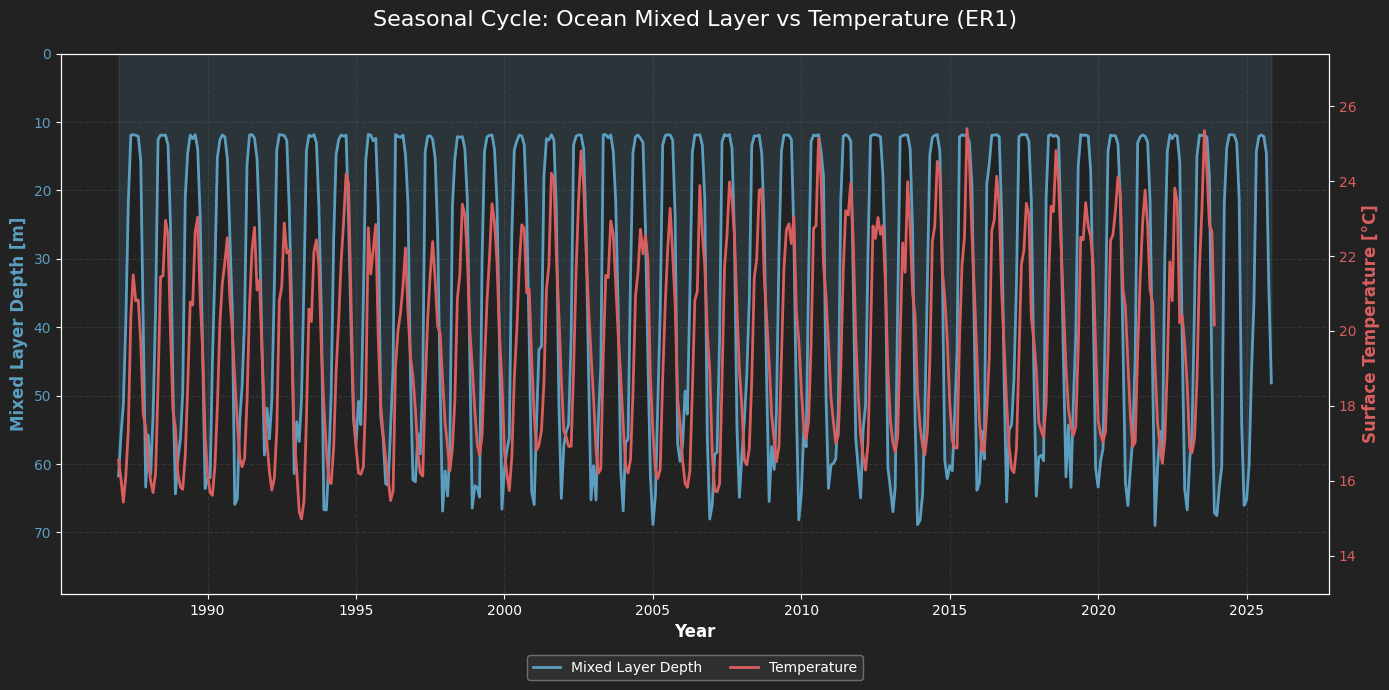

Done.


In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import warnings
import glob
import sys
import numpy as np

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Helper Function to Find Folders ---
def find_data_path(target_folder, subfolder):
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        if target_folder in os.path.basename(root) and subfolder in dirs:
            return os.path.join(root, subfolder)
        if target_folder in dirs:
            possible_path = os.path.join(root, target_folder, subfolder)
            if os.path.exists(possible_path):
                return possible_path
    return None

# --- Helper Function to Load & Sanitize a Single File ---
def load_and_sanitize(file_path, engine='netcdf4'):
    """
    Opens a file and rounds coordinates to 5 decimal places
    to prevent 'non-monotonic index' errors.
    """
    try:
        ds = xr.open_dataset(file_path, engine=engine, chunks={"time": -1})

        # FIX: Round the 'depth' coordinate if it exists to fix the specific error
        if 'depth' in ds.coords:
            ds.coords['depth'] = np.round(ds.coords['depth'], 5)

        return ds
    except Exception as e:
        print(f"Skipping corrupt file: {os.path.basename(file_path)} ({e})")
        return None

# --- Main Execution for ER1 ---
region_name = "ER1"
print(f"--- Processing {region_name} ---")

# 1. Locate Folders
path_temp_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_mld_dir = find_data_path(region_name, "MIXED_LAYER_DEPTH")

if path_temp_dir and path_mld_dir:
    print(f"Found Temp Dir: {path_temp_dir}")
    print(f"Found MLD Dir:  {path_mld_dir}")

    # Get sorted file lists (Sorting is CRITICAL for time series)
    files_temp = sorted(glob.glob(os.path.join(path_temp_dir, "*.nc")))
    files_mld = sorted(glob.glob(os.path.join(path_mld_dir, "*.nc")))

    if not files_temp:
        print("CRITICAL: No files found in Temperature folder.")
        sys.exit()

    # 2. Manual Loading Loop (The Bulletproof Fix)
    print("Loading files individually to fix coordinate errors...")

    # --- Load Temperature ---
    temp_datasets = []
    print(f"Processing {len(files_temp)} Temperature files...")
    for f in files_temp:
        ds = load_and_sanitize(f)
        if ds: temp_datasets.append(ds)

    # --- Load MLD ---
    mld_datasets = []
    print(f"Processing {len(files_mld)} MLD files...")
    for f in files_mld:
        ds = load_and_sanitize(f)
        if ds: mld_datasets.append(ds)

    if not temp_datasets or not mld_datasets:
        print("Error: No valid datasets could be loaded.")
        sys.exit()

    # 3. Concatenate
    print("Concatenating datasets...")
    # We use join='override' here which is very aggressive at ignoring differences
    try:
        ds_temp = xr.concat(temp_datasets, dim='time', coords='minimal', compat='override')
        ds_mld = xr.concat(mld_datasets, dim='time', coords='minimal', compat='override')
    except Exception as e:
        print(f"Concatenation failed: {e}")
        sys.exit()

    print("Merging MLD and Temp...")
    # Use inner join to keep only time steps that exist in BOTH
    ds_combined = xr.merge([ds_mld, ds_temp], join='inner')

    # 4. Process Monthly Means
    print("Resampling to monthly means...")
    if 'depth' in ds_combined['thetao'].coords:
        surface_temp = ds_combined['thetao'].isel(depth=0)
    else:
        surface_temp = ds_combined['thetao']

    mld = ds_combined['mlotst']

    # Load into memory now
    mld_monthly = mld.resample(time='1MS').mean().compute()
    temp_monthly = surface_temp.resample(time='1MS').mean().compute()

    # 5. Plotting
    print("Generating Plot...")
    plt.style.use('dark_background')
    fig, ax1 = plt.subplots(figsize=(14, 7))
    fig.patch.set_facecolor('#222222')
    ax1.set_facecolor('#222222')

    # Left Axis: MLD
    color_mld = '#5c9ebf'
    ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
    ax1.set_ylabel('Mixed Layer Depth [m]', color=color_mld, fontsize=12, fontweight='bold')
    ax1.fill_between(mld_monthly.time, mld_monthly, 0, color=color_mld, alpha=0.15)
    ax1.plot(mld_monthly.time, mld_monthly, color=color_mld, linewidth=2, label='Mixed Layer Depth')
    ax1.tick_params(axis='y', labelcolor=color_mld, colors='white')
    ax1.tick_params(axis='x', colors='white')
    ax1.invert_yaxis()

    # Safety for Y-limits
    max_mld_val = float(mld_monthly.max()) if mld_monthly.max().notnull() else 100
    ax1.set_ylim(max_mld_val + 10, 0)

    # Right Axis: Temperature
    ax2 = ax1.twinx()
    color_temp = '#d95f5f'
    ax2.set_ylabel('Surface Temperature [°C]', color=color_temp, fontsize=12, fontweight='bold')
    ax2.plot(temp_monthly.time, temp_monthly, color=color_temp, linewidth=2, label='Temperature')
    ax2.tick_params(axis='y', labelcolor=color_temp, colors='white')

    # Smart Limits
    min_temp = float(temp_monthly.min()) - 2 if temp_monthly.min().notnull() else 0
    max_temp = float(temp_monthly.max()) + 2 if temp_monthly.max().notnull() else 30
    ax2.set_ylim(min_temp, max_temp)

    # Title & Legend
    plt.title(f"Seasonal Cycle: Ocean Mixed Layer vs Temperature ({region_name})", fontsize=16, color='white', pad=20)
    ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
               loc='upper center', bbox_to_anchor=(0.5, -0.1),
               ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

    plt.tight_layout()
    plt.show()
    print("Done.")

else:
    print(f"Error: Could not find folder paths for {region_name}.")

--- Processing ER1: Ocean vs Atmospheric Temperature ---
Loading Ocean Temperature files...
Loading Atmospheric Data...
Correlation (r): 0.887


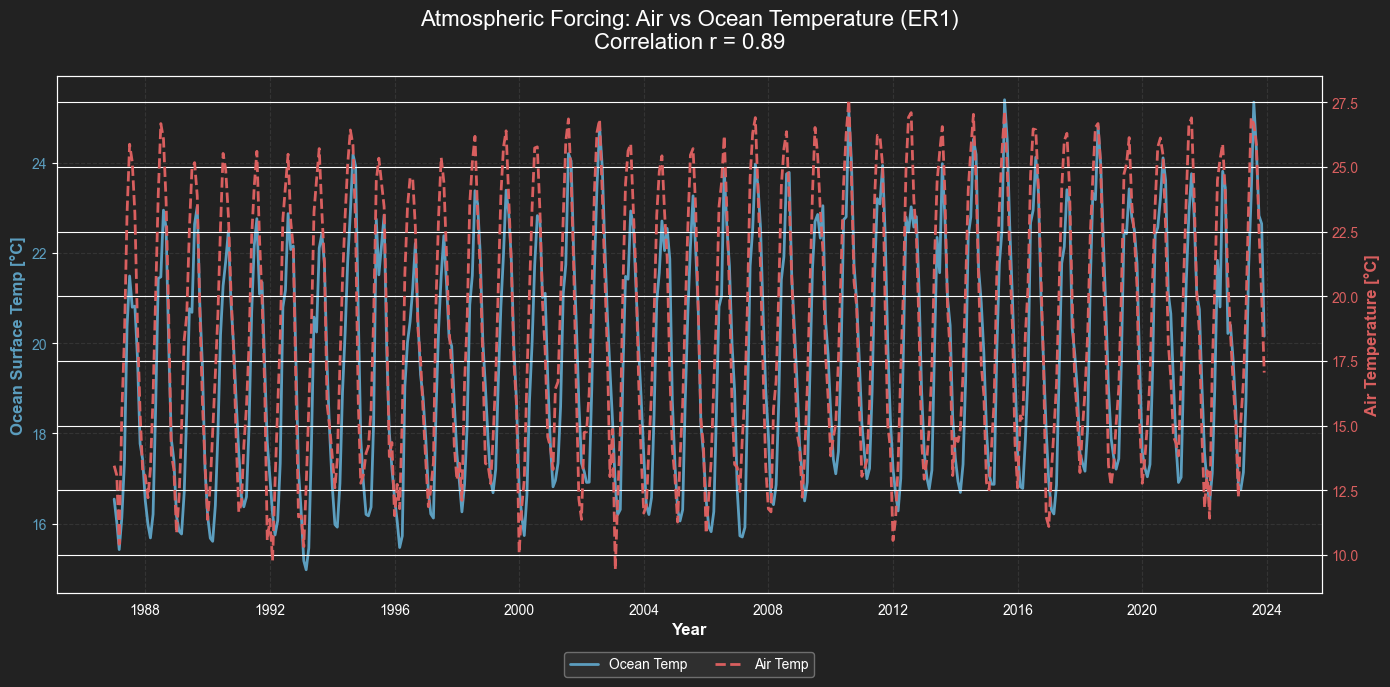

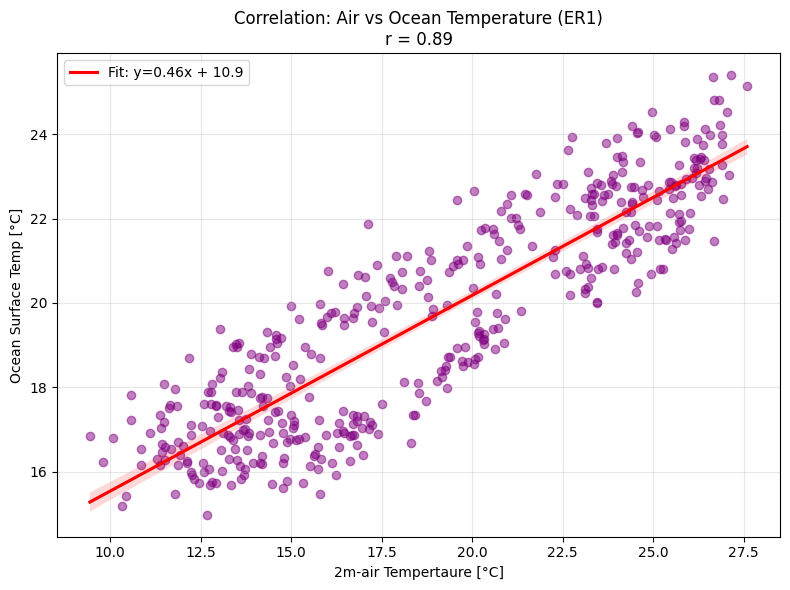

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
import glob
import numpy as np

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
region_name = "ER1"
atmos_filename_pattern = "ATMOSPHERIC_DATA"

print(f"--- Processing {region_name}: Ocean vs Atmospheric Temperature ---")

# --- Helper Function to Find Folders ---
def find_data_path(target_folder, subfolder_or_file):
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        # Case 1: subfolder inside region folder
        if target_folder in os.path.basename(root) and subfolder_or_file in dirs:
            return os.path.join(root, subfolder_or_file)

        # Case 2: File inside region folder
        if target_folder in os.path.basename(root):
            for file in files:
                if subfolder_or_file in file:
                    return os.path.join(root, file)

        # Case 3: Direct check if path exists
        possible_path = os.path.join(root, target_folder, subfolder_or_file)
        if os.path.exists(possible_path):
            return possible_path
    return None

# --- Helper Function to Load & Sanitize (From your code) ---
def load_and_sanitize(file_path, engine='netcdf4'):
    try:
        ds = xr.open_dataset(file_path, engine=engine, chunks={"time": -1})
        # FIX: Round the 'depth' coordinate to prevent 'non-monotonic index' errors
        if 'depth' in ds.coords:
            ds.coords['depth'] = np.round(ds.coords['depth'], 5)
        return ds
    except Exception as e:
        print(f"Skipping corrupt file: {os.path.basename(file_path)} ({e})")
        return None

# 1. Locate Data
path_ocean_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_atmos_file = find_data_path(region_name, atmos_filename_pattern)

if path_ocean_dir and path_atmos_file:
    # -----------------------------
    # 2. Load Ocean Temperature (Robust Loop)
    # -----------------------------
    print("Loading Ocean Temperature files...")
    files_temp = sorted(glob.glob(os.path.join(path_ocean_dir, "*.nc")))

    if not files_temp:
        print("CRITICAL: No files found in Temperature folder.")
    else:
        temp_datasets = []
        for f in files_temp:
            ds = load_and_sanitize(f)
            if ds: temp_datasets.append(ds)

        # Concatenate
        try:
            ds_temp = xr.concat(temp_datasets, dim='time', coords='minimal', compat='override')

            # Select Surface Temperature
            if 'depth' in ds_temp['thetao'].dims:
                surface_temp = ds_temp['thetao'].isel(depth=0)
            elif 'lev' in ds_temp['thetao'].dims:
                surface_temp = ds_temp['thetao'].isel(lev=0)
            else:
                surface_temp = ds_temp['thetao']

            # Spatial Mean
            if 'lat' in surface_temp.dims:
                surface_temp = surface_temp.mean(dim=['lat', 'lon'])

            # Resample Ocean to Monthly Mean
            ocean_monthly = surface_temp.resample(time='1MS').mean().compute()

        except Exception as e:
            print(f"Concatenation failed: {e}")
            ocean_monthly = None

    # -----------------------------
    # 3. Load Atmospheric Data (CSV)
    # -----------------------------
    if ocean_monthly is not None:
        print("Loading Atmospheric Data...")
        df_atmos = pd.read_csv(path_atmos_file)

        # Clean column names
        df_atmos.columns = [c.strip() for c in df_atmos.columns]

        # Parse Dates
        try:
            df_atmos['time'] = pd.to_datetime(df_atmos['time'], format='%d-%m-%y %H:%M')
        except:
            df_atmos['time'] = pd.to_datetime(df_atmos['time'])

        # Identify Air Temperature Column
        air_temp_col = [c for c in df_atmos.columns if 'temp' in c.lower() and 'air' in c.lower()]

        if air_temp_col:
            col_name = air_temp_col[0]
            # Select only numeric columns to avoid "SR1/ER1" text errors
            atmos_monthly = df_atmos.set_index('time')[[col_name]].resample('1MS').mean()

            # Convert to Xarray
            ds_atmos = xr.Dataset.from_dataframe(atmos_monthly)

            # -----------------------------
            # 4. Merge & Correlate
            # -----------------------------
            ds_combined = xr.merge([ocean_monthly.rename('Ocean_Temp'), ds_atmos.rename({col_name: 'Air_Temp'})], join='inner')
            ds_combined = ds_combined.dropna(dim='time')

            if ds_combined.sizes['time'] > 2:
                # Calculate Correlation
                x = ds_combined['Air_Temp'].values
                y = ds_combined['Ocean_Temp'].values
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

                print(f"Correlation (r): {r_value:.3f}")

                # -----------------------------
                # 5. Plotting (Dark Theme)
                # -----------------------------
                plt.style.use('dark_background')
                fig, ax1 = plt.subplots(figsize=(14, 7))
                fig.patch.set_facecolor('#222222')
                ax1.set_facecolor('#222222')

                # Left Axis: Ocean Temperature
                color_ocean = '#5c9ebf' # Cyan/Blue
                ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
                ax1.set_ylabel('Ocean Surface Temp [°C]', color=color_ocean, fontsize=12, fontweight='bold')
                ax1.plot(ds_combined.time, ds_combined['Ocean_Temp'], color=color_ocean, linewidth=2, label='Ocean Temp')
                ax1.tick_params(axis='y', labelcolor=color_ocean, colors='white')
                ax1.tick_params(axis='x', colors='white')

                # Right Axis: Air Temperature
                ax2 = ax1.twinx()
                color_air = '#d95f5f' # Salmon/Red
                ax2.set_ylabel('Air Temperature [°C]', color=color_air, fontsize=12, fontweight='bold')
                ax2.plot(ds_combined.time, ds_combined['Air_Temp'], color=color_air, linewidth=2, linestyle='--', label='Air Temp')
                ax2.tick_params(axis='y', labelcolor=color_air, colors='white')

                # Title & Legend
                plt.title(f"Atmospheric Forcing: Air vs Ocean Temperature ({region_name})\nCorrelation r = {r_value:.2f}", fontsize=16, color='white', pad=20)
                ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

                lines_1, labels_1 = ax1.get_legend_handles_labels()
                lines_2, labels_2 = ax2.get_legend_handles_labels()
                ax1.legend(lines_1 + lines_2, labels_1 + labels_2,
                           loc='upper center', bbox_to_anchor=(0.5, -0.1),
                           ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

                plt.tight_layout()
                plt.show()

                # --- Scatter Plot (Scientific) ---
                plt.style.use('default') # Reset for clean scatter
                plt.figure(figsize=(8, 6))
                sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5, 'color':'purple'}, line_kws={'color':'red', 'label':f'Fit: y={slope:.2f}x + {intercept:.1f}'})
                plt.xlabel(f'{col_name} [°C]')
                plt.ylabel('Ocean Surface Temp [°C]')
                plt.title(f"Correlation: Air vs Ocean Temperature ({region_name})\nr = {r_value:.2f}")
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

            else:
                print("Not enough overlapping data points for correlation.")
        else:
             print("Could not find 'Air Temperature' column in CSV.")
else:
    print(f"Error: Could not find data folders for {region_name}.")

--- Processing ER1: MLD vs Ocean Temperature ---
Found Temp: .\ER1-20251125T132711Z-1-001\ER1\OCEAN_TEMPERATURE
Found MLD:  .\ER1-20251125T132711Z-1-001\ER1\MIXED_LAYER_DEPTH
Loading 39 Temp files and 39 MLD files...
Calculating Monthly Means...

RESULTS:
Correlation (r): -0.721
R-squared: 0.520
P-value: 0.00000 (Significant if < 0.05)


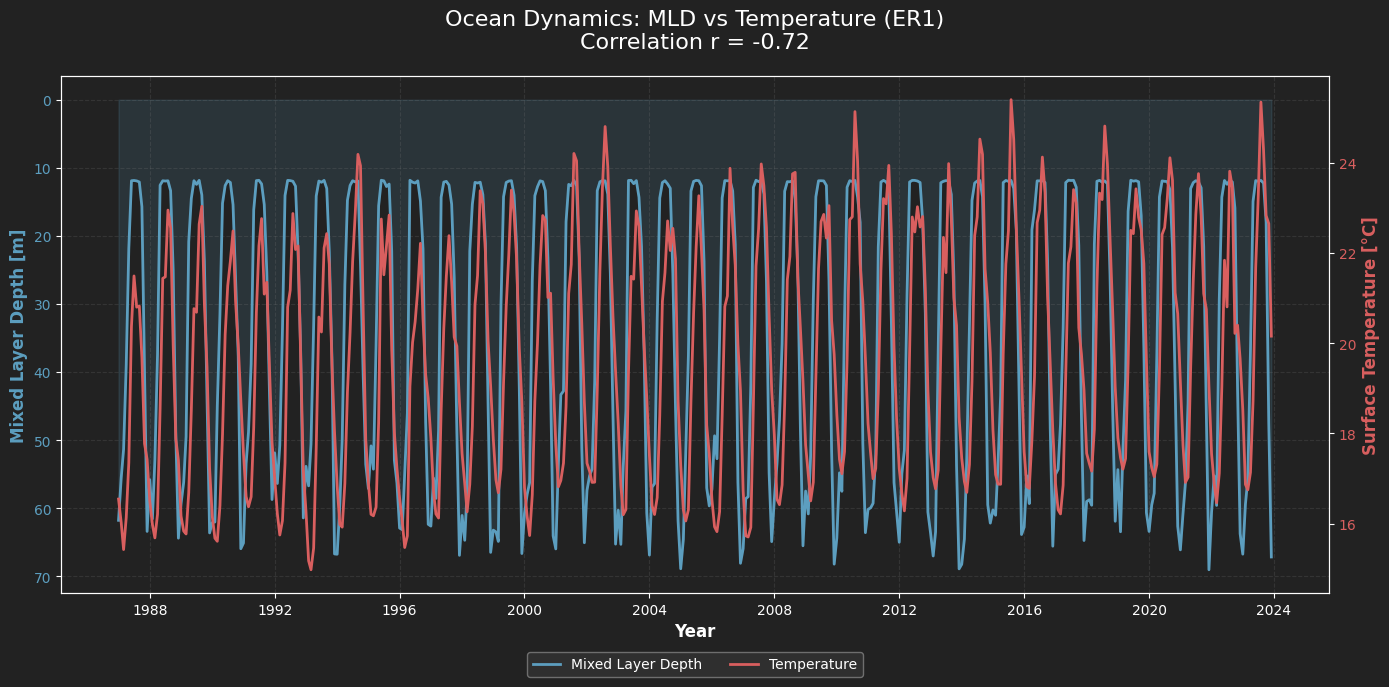

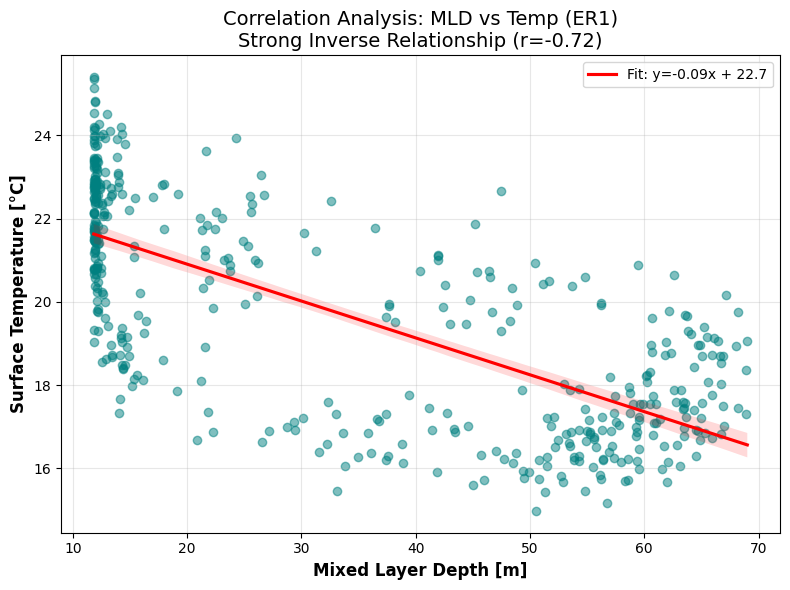

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
import glob
import numpy as np

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
region_name = "ER1" # Change to "WR1" or "SR1" if needed

print(f"--- Processing {region_name}: MLD vs Ocean Temperature ---")

# --- Helper 1: Find Folders Automatically ---
def find_data_path(target_folder, subfolder):
    start_search = "."
    for root, dirs, files in os.walk(start_search):
        if target_folder in os.path.basename(root) and subfolder in dirs:
            return os.path.join(root, subfolder)
        if target_folder in dirs:
             possible_path = os.path.join(root, target_folder, subfolder)
             if os.path.exists(possible_path):
                 return possible_path
    return None

# --- Helper 2: Load & Sanitize (The "Bulletproof" Fix) ---
def load_and_sanitize(file_path):
    """
    Opens a NetCDF file and rounds coordinates to 5 decimal places.
    This fixes 'non-monotonic index' errors common in ocean data.
    """
    try:
        ds = xr.open_dataset(file_path, chunks={"time": -1})

        # FIX: Round the 'depth' coordinate if it exists
        if 'depth' in ds.coords:
            ds.coords['depth'] = np.round(ds.coords['depth'], 5)

        return ds
    except Exception as e:
        print(f"Warning: Skipping corrupt file {os.path.basename(file_path)}: {e}")
        return None

# 1. Locate Data Folders
path_temp_dir = find_data_path(region_name, "OCEAN_TEMPERATURE")
path_mld_dir = find_data_path(region_name, "MIXED_LAYER_DEPTH")

if path_temp_dir and path_mld_dir:
    print(f"Found Temp: {path_temp_dir}")
    print(f"Found MLD:  {path_mld_dir}")

    # 2. Robust Loading Loop
    # We load files into a list first, then concatenate. This is safer than open_mfdataset for messy files.
    temp_files = sorted(glob.glob(os.path.join(path_temp_dir, "*.nc")))
    mld_files = sorted(glob.glob(os.path.join(path_mld_dir, "*.nc")))

    if not temp_files or not mld_files:
        print("CRITICAL ERROR: No .nc files found in one of the folders.")
    else:
        print(f"Loading {len(temp_files)} Temp files and {len(mld_files)} MLD files...")

        # Load Temp
        ds_temp_list = [load_and_sanitize(f) for f in temp_files]
        ds_temp_list = [ds for ds in ds_temp_list if ds is not None] # Remove None

        # Load MLD
        ds_mld_list = [load_and_sanitize(f) for f in mld_files]
        ds_mld_list = [ds for ds in ds_mld_list if ds is not None]

        # Concatenate (Force compatibility)
        try:
            ds_temp = xr.concat(ds_temp_list, dim='time', coords='minimal', compat='override')
            ds_mld = xr.concat(ds_mld_list, dim='time', coords='minimal', compat='override')
        except Exception as e:
            print(f"Concatenation failed: {e}")
            ds_temp = None

        if ds_temp is not None:
            # 3. Process Variables
            # Extract Surface Temperature
            if 'depth' in ds_temp['thetao'].dims:
                surface_temp = ds_temp['thetao'].isel(depth=0)
            elif 'lev' in ds_temp['thetao'].dims:
                surface_temp = ds_temp['thetao'].isel(lev=0)
            else:
                surface_temp = ds_temp['thetao']

            # Spatial Mean (if lat/lon exist)
            if 'lat' in surface_temp.dims:
                surface_temp = surface_temp.mean(dim=['lat', 'lon'])

            # Extract MLD
            mld = ds_mld['mlotst']
            if 'lat' in mld.dims:
                mld = mld.mean(dim=['lat', 'lon'])

            # Resample to Monthly Means (Smoothes data)
            print("Calculating Monthly Means...")
            mld_monthly = mld.resample(time='1MS').mean().compute()
            temp_monthly = surface_temp.resample(time='1MS').mean().compute()

            # Merge for alignment
            ds_combined = xr.merge([mld_monthly.rename('MLD'), temp_monthly.rename('Temp')], join='inner')
            ds_combined = ds_combined.dropna(dim='time')

            # 4. Statistical Analysis
            x = ds_combined['MLD'].values
            y = ds_combined['Temp'].values

            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            print(f"\nRESULTS:\nCorrelation (r): {r_value:.3f}")
            print(f"R-squared: {r_value**2:.3f}")
            print(f"P-value: {p_value:.5f} (Significant if < 0.05)")

            # --- PLOT 1: Dark Mode Time Series ---
            plt.style.use('dark_background')
            fig, ax1 = plt.subplots(figsize=(14, 7))
            fig.patch.set_facecolor('#222222')
            ax1.set_facecolor('#222222')

            # Left Axis: MLD (Cyan)
            color_mld = '#5c9ebf'
            ax1.set_xlabel('Year', fontsize=12, color='white', fontweight='bold')
            ax1.set_ylabel('Mixed Layer Depth [m]', color=color_mld, fontsize=12, fontweight='bold')
            ax1.fill_between(ds_combined.time, ds_combined['MLD'], 0, color=color_mld, alpha=0.15)
            ax1.plot(ds_combined.time, ds_combined['MLD'], color=color_mld, linewidth=2, label='Mixed Layer Depth')
            ax1.tick_params(axis='y', labelcolor=color_mld, colors='white')
            ax1.tick_params(axis='x', colors='white')
            ax1.invert_yaxis() # Convention: Depth goes down

            # Right Axis: Temp (Red)
            ax2 = ax1.twinx()
            color_temp = '#d95f5f'
            ax2.set_ylabel('Surface Temperature [°C]', color=color_temp, fontsize=12, fontweight='bold')
            ax2.plot(ds_combined.time, ds_combined['Temp'], color=color_temp, linewidth=2, label='Temperature')
            ax2.tick_params(axis='y', labelcolor=color_temp, colors='white')

            # Title & Legend
            plt.title(f"Ocean Dynamics: MLD vs Temperature ({region_name})\nCorrelation r = {r_value:.2f}", fontsize=16, color='white', pad=20)
            ax1.grid(True, linestyle='--', alpha=0.2, color='gray')

            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=True, facecolor='#333333', edgecolor='gray', labelcolor='white')

            plt.tight_layout()
            plt.show()

            # --- PLOT 2: Scientific Scatter Plot ---
            plt.style.use('default') # Reset to white
            plt.figure(figsize=(8, 6))

            sns.regplot(x=x, y=y, scatter_kws={'alpha':0.5, 'color':'teal'}, line_kws={'color':'red', 'label':f'Fit: y={slope:.2f}x + {intercept:.1f}'})

            plt.xlabel('Mixed Layer Depth [m]', fontsize=12, fontweight='bold')
            plt.ylabel('Surface Temperature [°C]', fontsize=12, fontweight='bold')
            plt.title(f"Correlation Analysis: MLD vs Temp ({region_name})\nStrong Inverse Relationship (r={r_value:.2f})", fontsize=14)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

else:
    print(f"Error: Could not find data folders for {region_name}.")